<div style="background-color:	#600170; text-align:center; vertical-align: middle; padding:40px 0; margin-top:30px">
<h1 style="color:white">DL&CV - Karaoke</h1>
<b style="color:white">Tim Oosterling, Busse Heemskerk, Casper De Knecht, Jasper Duncker</b>
    </div>
<a name='start'></a>

## Table of contents

0. [Data inladen en functies](#0.0)

1. [EDA (Exploratory Data Analysis)](#1.0)


2. [LSTM voor audioclips](#2.0)
    - [&sect;2.1: ](#2.1)
    - [&sect;2.2: ](#2.2)


3. [LSTM voor songteksten](#3.0)
    - [&sect;3.1: ](#3.1)
    - [&sect;3.2: ](#3.2)
    - [&sect;3.3: ](#3.3)
    
    
4. [Transformer voor songteksten](#4.0)
    - [&sect;4.1: Aanmaken van de juiste datasets](#4.1)
    - [&sect;4.2: Aanmaken en fine-tuning van het model](#4.2)


5. [Model naar keuze](#5.0)
    - [&sect;5.1: ](#5.1)
    - [&sect;5.2: ](#5.2)


6. [Bevindingen](#6.0)
    - [&sect;6.1: ](#6.1)
    - [&sect;6.2: ](#6.2)
    
    
7. [Conclusie en aanbevelingen](#7.0)
    - [&sect;7.1: ](#7.1)
    - [&sect;7.2: ](#7.2)
    - [&sect;7.3: ](#7.3)

<p>Voor het gebruik van dit notebook zijn de volgende libraries nodig.</p>


[Back to the top](#start)
<a name='0.0'></a>
<div style="background-color:#600170; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H0: Data inladen en functies </strong></h2>
</div>

Om de data te kunnen onderzoeken is het belangrijk dat alle nodige libaries ervoor worden geinstalleerd. Naast de standaard libaries is er ook een `.py` bestand aanwezig in de GitHub, in dit bestand staan diverse functies die zijn ontwikkelt voor gebruik in het notebook.

In [31]:
# Inladen van alle dependecies en functies in functies.py
from functies import *
from datetime import datetime

# Importeren van nodige libaries bij inladen
from pathlib import Path

# Importeren EDA
from IPython.display import Audio
from collections import Counter
import string
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Importeren DL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TextVectorization, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
#from keras.utils.vis_utils import plot_model
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from librosa.core import amplitude_to_db
from librosa.display import specshow
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


Ook zijn er bepaalde standaard opties die helpen in het notebook. Zo kan er een seed worden vastgezet, zodat het project kan worden gereproduceerd.

In [7]:
# Aanmaken van een SEED
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Downloaden van stopwords indien nog niet gedaan
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KaasT\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

Nu de nodige libaries zijn ingeladen is het tijd om de csv bestanden in te laden.

In [8]:
# Inladen van de train en test dataset
train_data = pd.read_csv("train.csv", sep=",")
test_data = pd.read_csv("test.csv", sep=",")

# Tonen van de eerste vijf regels
display(train_data.head(), test_data.head())

filename                                             lyrics  genre
0  blues.00001.wav  I’m in the Mood Lyrics[Verse 1]\nI'm in the mo...  blues
1  blues.00002.wav  (John Lee Hooker)\nThink twice before you go, ...  blues
2  blues.00003.wav  [Intro, Spoken]\n...A little thing I'm going t...  blues
3  blues.00005.wav  Sugar mama, sugar mama, sugar mama please come...  blues
4  blues.00006.wav  My baby left me this morning\nPeople just arou...  blues

filename                                             lyrics
0  test.00000.wav  [Instrumental Intro]\n(Radio)\n(Radio)\n[Verse...
1  test.00001.wav  [Verse 1]\nThere's an old Kodak camera in my d...
2  test.00002.wav  [Intro]\nSo curious, so curious\n\n[Verse 1]\n...
3  test.00003.wav  [Intro]\nWhere do I take this pain of mine\nI ...
4  test.00004.wav  [Verse 1]\nBaby's into runnin' around, hangin'...

Naast het inladen van de csv bestanden zijn er ook nog audio fragmenten die moeten worden ingeladen.

In [9]:
# Geven van de directories
train_dir = "Train"
test_dir = "Test"

# Aanmaken van de train en validation datasets
train_ds, val_ds = keras.utils.audio_dataset_from_directory(
    directory=train_dir,
    batch_size=4,
    validation_split=0.2,
    seed=SEED,
    output_sequence_length=30*22050,
    subset='both'
    )

# Aanmaken van de test dataset
test_ds = keras.utils.audio_dataset_from_directory(
    directory=test_dir,
    batch_size=1,
    seed=SEED,
    label_mode=None,
    output_sequence_length=30*22050
    )

Found 537 files belonging to 8 classes.
Using 430 files for training.
Using 107 files for validation.
Found 129 files.


[Back to the top](#start)
<a name='1.0'></a>
<a name='1.1'></a>
<div style="background-color:#600170; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H1: EDA (Exploratory Data Analysis)</strong></h2>
</div>

De bestanden die ingeladen zijn bestaan uit twee categorieen, audio en lyrics. Beide typen data hebben andere kenmerken die van belang kunnen zijn voor het maken van voorspelling, daarom zal er gekeken worden naar verschillende mogelijke kenmerken die patronen binnen de data kunnen aangeven. Eerst wordt de audio data bekeken.

<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:20px; font-weight:bold;">Audio data analyse</div>
</div>
<br>


In [ ]:
Audio(
    data="Train/blues/blues.00002.wav",
    rate=22050
)

[Back to the top](#start)

<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:20px; font-weight:bold;">Tekst data analyse</div>
</div>

Voor de lyrics zijn er verschillende statistieken die interessant kunnen zijn het begrijpen van de tekst. Om deze statistieken te kunnen bekijken moet de tekst worden opgesplitst. Deze opsplitsing maakt het mogelijk om de woorden te gebruiken voor statistische analyse. Eerst zal er gekeken worden naar het aantal keren dat de genres voorkomen in de dataset.

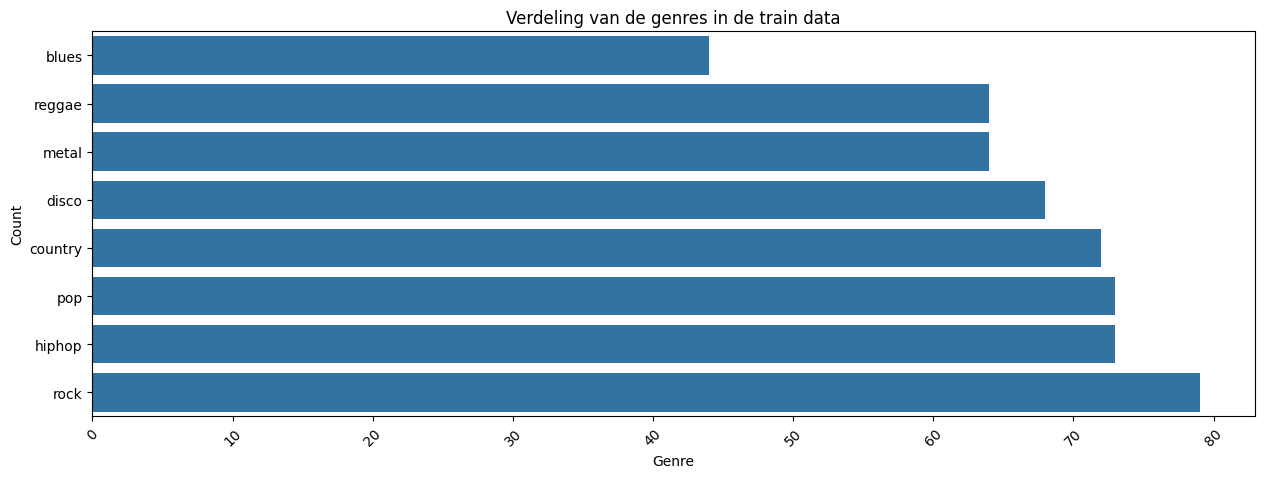

In [ ]:
# Kopie maken van train_data
eda = train_data.copy()

# Bepalen van het aantal keren dat genres voorkomen
genre_counts = eda['genre'].value_counts()

# Orderen van de genres
ordered_genres = genre_counts.index[::-1]

# Aanmaken countplot
plt.figure(figsize=(15, 5))
sns.countplot(
    data=eda, y='genre', order=ordered_genres
    )

# Titel en assen
plt.title('Verdeling van de genres in de train data')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Zoals er is te zien is er een redelijke representatie van de genres, alleen het genre blues heeft een stuk minder items in de data staan. Dit is niet heel erg, maar zou wel tot minder krachtige voorspellingen kunnen leiden.

Om verder de data in te duiken zal de tekst getokenized worden. Dit geeft de mogelijkheid om de data te visualiseren per woord.

In [ ]:
def tokenize_text(text):
    """
    Deze functie maakt tokens van de tekst en haalt
    tekens als [] en () weg uit de tekst.
    """
    # Weghalen van brackets
    text = re.sub(r'[\[\(\{][^\]\)\}]*[\]\)\}]', ' ', text)

    # Maken van een tokenize patroon met regex
    pattern = r'''
        (?x)
        (?<![a-zA-Z])
        (?:\w+(?:'\w+)?)
        |(?:\w(?:-\w+)+)
        |\S
    '''

    # Tokenizen van de tekst
    tokens = regexp_tokenize(text, pattern, flags=re.VERBOSE)

    return tokens

# Maken van de tokens kolom op basis van de lyrics
eda['tokens'] = eda['lyrics'].apply(tokenize_text)

Met de tokens is het mogelijk om een beter begrip te krijgen van de mogelijkheden van de preprocessing. Een belangrijke factor hierbij is de aanwezigheid en hoeveelheid van stopwoorden in de tekst. Om te kijken of er een overvloed aan stopwoorden aanwezig is, worden er 2 sets aan grafieken gemaakt. De eerste set visualiseerd de meest voorkomende woorden die te vinden zijn in alle teksten. De tweede sets aan visualisaties doen dit apart per genre en zonder stopwoorden.

Om te zorgen dat we deze data op de juiste manier kunnen visualiseren zijn er meerdere handelingen nodig. We beginnen met het aanmaken van wat standaarden die gebruikt gaan worden:
- translator, deze vertaler haalt alle interpunctie uit de tekst. Dit zorgt ervoor dat we geen interpunctie tokens in de tekst hebben.
- word_counts, deze variabel bevat de aantallen van elk woord in de tekst.
- general_words, deze variabel bevat de top_n meest voorkomende woorden.
- grouped, een dataframe waar de genres gegroupeerd zijn.

In [ ]:
# Aanmaken translator voor interpunctie
translator = str.maketrans('', '', string.punctuation)

# Zorgen voor alleen gevulde tokens en fiteren interpunctie
all_words = [
    token.translate(translator).strip()
    for tokens in eda['tokens']
    for token in tokens
    if token.translate(translator).strip()
    ]

# Tellen van de aantallen met Counter
word_counts = Counter(all_words)

# Ophalen van de top_n woorden
top_n = 10
general_top_words = word_counts.most_common(top_n)
general_words, general_counts = zip(*general_top_words)

# Group de data per genre
grouped = eda.groupby('genre')

Nu kunnen we een dataframe aanmaken die voor elk genre de 10 algemeen meest voorkomende woorden bevat.

In [ ]:
# Lege list aanmaken
data = []

# Itereren over de genres
for genre, group in grouped:
    # Zorgen voor alleen gevulde tokens en fiteren interpunctie
    all_words = [
        token.translate(translator).strip()
        for tokens in group['tokens']
        for token in tokens
        if token.translate(translator).strip()
        ]

    # Tellen van alle woorden
    genre_word_counts = Counter(all_words)

    # Tellen van meest voorkomende woorden per genre
    counts_per_genre = [genre_word_counts[word] for word in general_words]

    # Opslaan van dicts in de list
    for word, count in zip(general_words, counts_per_genre):
        data.append({
            'Word': word,
            'Count': count,
            'Genre': genre
        })

# Omzetten van list naar dataframe
df = pd.DataFrame(data)

Met de data voorbereid kan de visualisatie worden getoont.

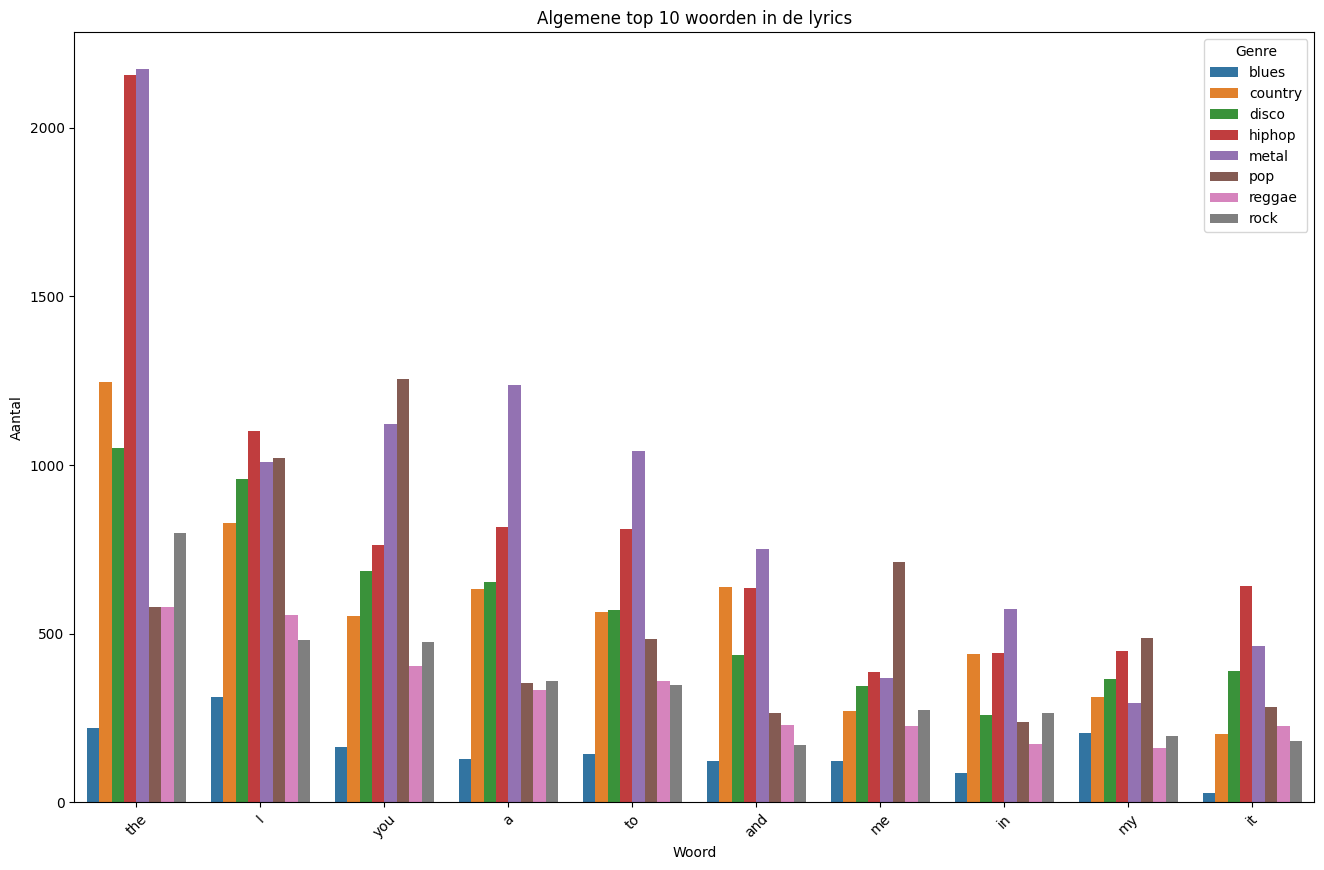

In [ ]:
# Plotten van de woordaantallen
plt.figure(figsize=(16, 10))
sns.barplot(x='Word', y='Count', hue='Genre', data=df, errorbar=None)

# Assen en titel
plt.title(f'Algemene top {top_n} woorden in de lyrics')
plt.xlabel('Woord')
plt.ylabel('Aantal')
plt.xticks(rotation=45)
plt.show()

Zoals er is te zien in de bovenstaande visualisatie, zijn er bij de meeste genres een paar pieken. Wat erg opvalt is de kleine hoeveelheid van de woorden er in blues zitten. Daarnaast lijken er wel enige patronen aan de stopwoorden verbonden te kunnen zitten. Om die reden is er besloten om zowel met als zonder stopwoorden de tekst data te fitten op de modellen.

Nu gaan we door naar de tweede set aan visualisaties. Hiervoor moet eerst de tekst goed en zorgvuldig worden opgeschoond.

In [10]:
def clean_text(text, stopword=True):
    """
    Deze functie schoont de teksten
    op door middel van regex
    """
    # Defineren van stopwoorden
    stop_words = set(stopwords.words('english'))

    def clean_single_text(text):
        # Weghalen '\', 'n', etc.
        text = re.sub(r'\\[^\s]+', ' ', text)

        # Weghalen non-ASCII
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)

        # Weghalen van brackets en vulling
        text = re.sub(r'\[.*?\]', '', text)

        # Weghalen van haakjes en vulling
        text = re.sub(r'\(.*?\)', '', text)

        # Vervang 'lyrics' door whitespace
        text = re.sub('lyrics', ' ', text)

        # Weghalen overbodige whitespace
        text = text.strip()
        text = re.sub(r'\s+', ' ', text)

        # Omzetten tot lowercase
        text = text.lower()

        # Weghalen stopwoorden
        if stopword is True:
            words = re.findall(r'\b\w+\b', text)
            words = [word for word in words if word not in stop_words]
            text = ' '.join(words)

        return text

    # Toepassen van de functie op alle teksten
    return text.apply(clean_single_text)

Met de functie kunnen we de tekst gemakkelijk schoonmaken. Daarna moeten er weer standaarden worden aangemaakt voor de nieuwe teksten.

In [ ]:
# Aanmaken kolom met opgeschoonde tekst
eda['clean_lyrics'] = clean_text(eda['lyrics'])

# Tokens maken van de opgeschoonde tekst
eda['tokens'] = eda['clean_lyrics'].apply(tokenize_text)

# Zorgen voor alleen gevulde tokens en fiteren interpunctie
all_words = [
    token.translate(translator).strip()
    for tokens in eda['tokens']
    for token in tokens
    if token.translate(translator).strip()
    ]

# Tellen van de aantallen met Counter
word_counts = Counter(all_words)

# Ophalen van de top_n woorden
top_n = 10
general_top_words = word_counts.most_common(top_n)
general_words, general_counts = zip(*general_top_words)

# Hergroupeer de data per genre
grouped = eda.groupby('genre')

Nu we beschikken over schone tekst, kan er gekeken worden naar de meest voorkomende woorden. Voor deze visualisatie is er bij elk genre dezelfde 10 woorden te zien.

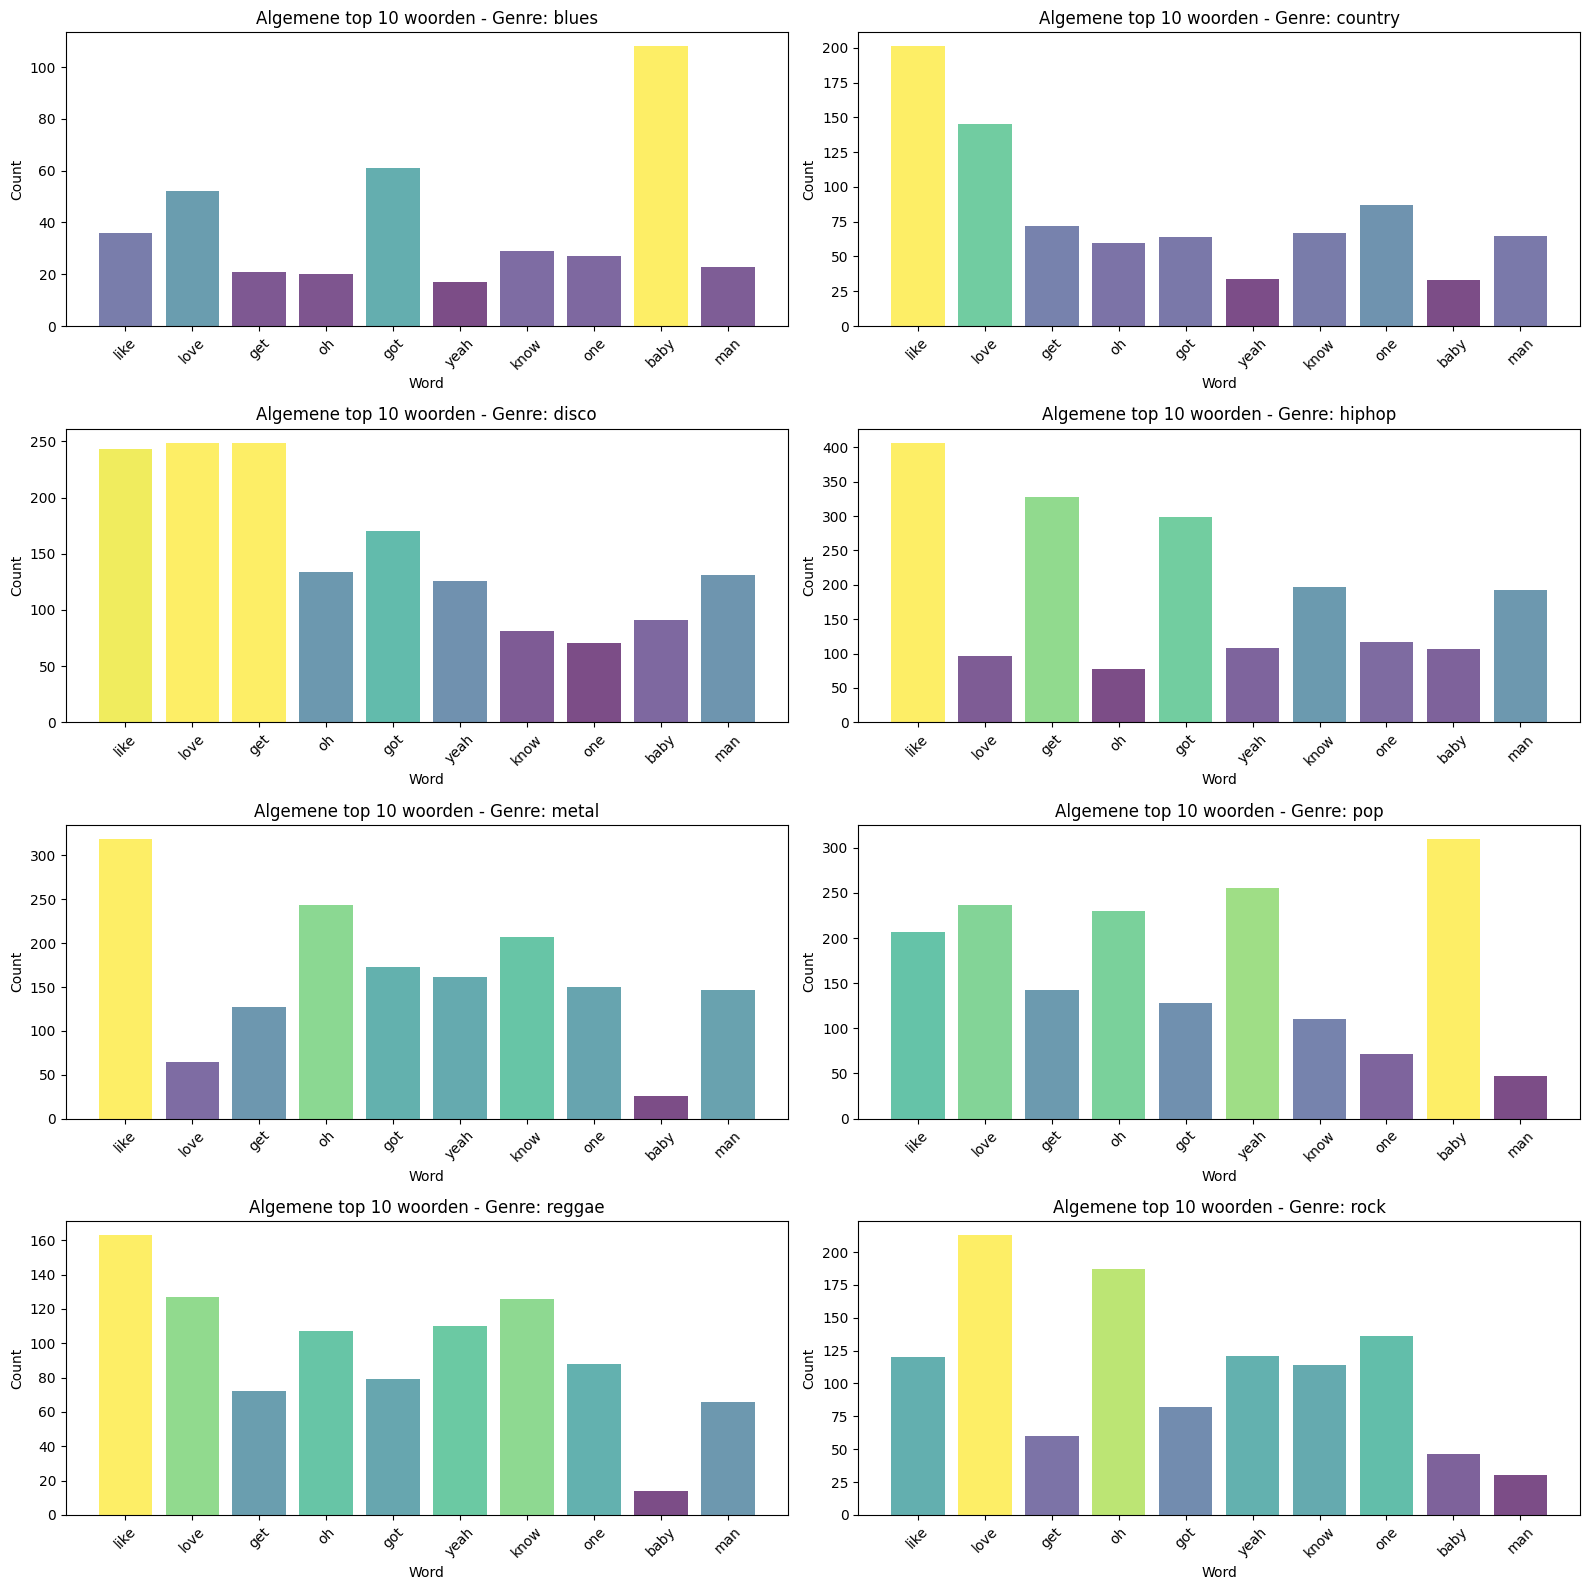

In [ ]:
# Maken van een 4 bij 2 plot
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes = axes.flatten()

# Itereer over de genres
for idx, (genre, group) in enumerate(grouped):
    if idx >= len(axes):
        break

    # Zorgen voor alleen gevulde tokens en fiteren interpunctie
    all_words = [
        token.translate(translator).strip()
        for tokens in group['tokens']
        for token in tokens
        if token.translate(translator).strip()
        ]

    # Tellen van alle woorden
    genre_word_counts = Counter(all_words)

    # Tellen van meest voorkomende woorden per genre
    counts_per_genre = [genre_word_counts[word] for word in general_words]

    # Maken van een colourmap op basis van het genre
    norm = Normalize(vmin=min(counts_per_genre), vmax=max(counts_per_genre))
    cmap = plt.get_cmap('viridis')

    # Maken van een lijst met kleuren gebaseerd op aantallen in het genre
    colors = [cmap(norm(count)) for count in counts_per_genre]

    # Plot de bars voor de plot
    ax = axes[idx]
    ax.bar(general_words, counts_per_genre, alpha=0.7, color=colors)
    ax.set_title(f'Algemene top {top_n} woorden - Genre: {genre}')
    ax.set_ylabel('Aantallen')
    ax.set_xlabel('Woord')
    ax.set_xticks(range(len(general_words)))
    ax.set_xticklabels(general_words, rotation=45)

# Verstoppen van extra assen
for idx in range(len(grouped), len(axes)):
    axes[idx].axis('off')

# Tonen van de plots
plt.tight_layout()
plt.show()

Deze grafieken tonen aan dat er hier en daar een verschil zit in het woordenboek van een genre. Zo zien we bij blues en pop erg veel counts van het woord baby, terwijl de rest van de genres vrij weinig baby gebruikt. Het meest voorkomende, overkoepelende woord tussen de geenres is like, gevolgd door love. Zo wordt like maar in drie genres niet veel gebruikt.

Nu gaan we nog een kijkje nemen naar de tien meest gebruikte woorden binnen elk genre.

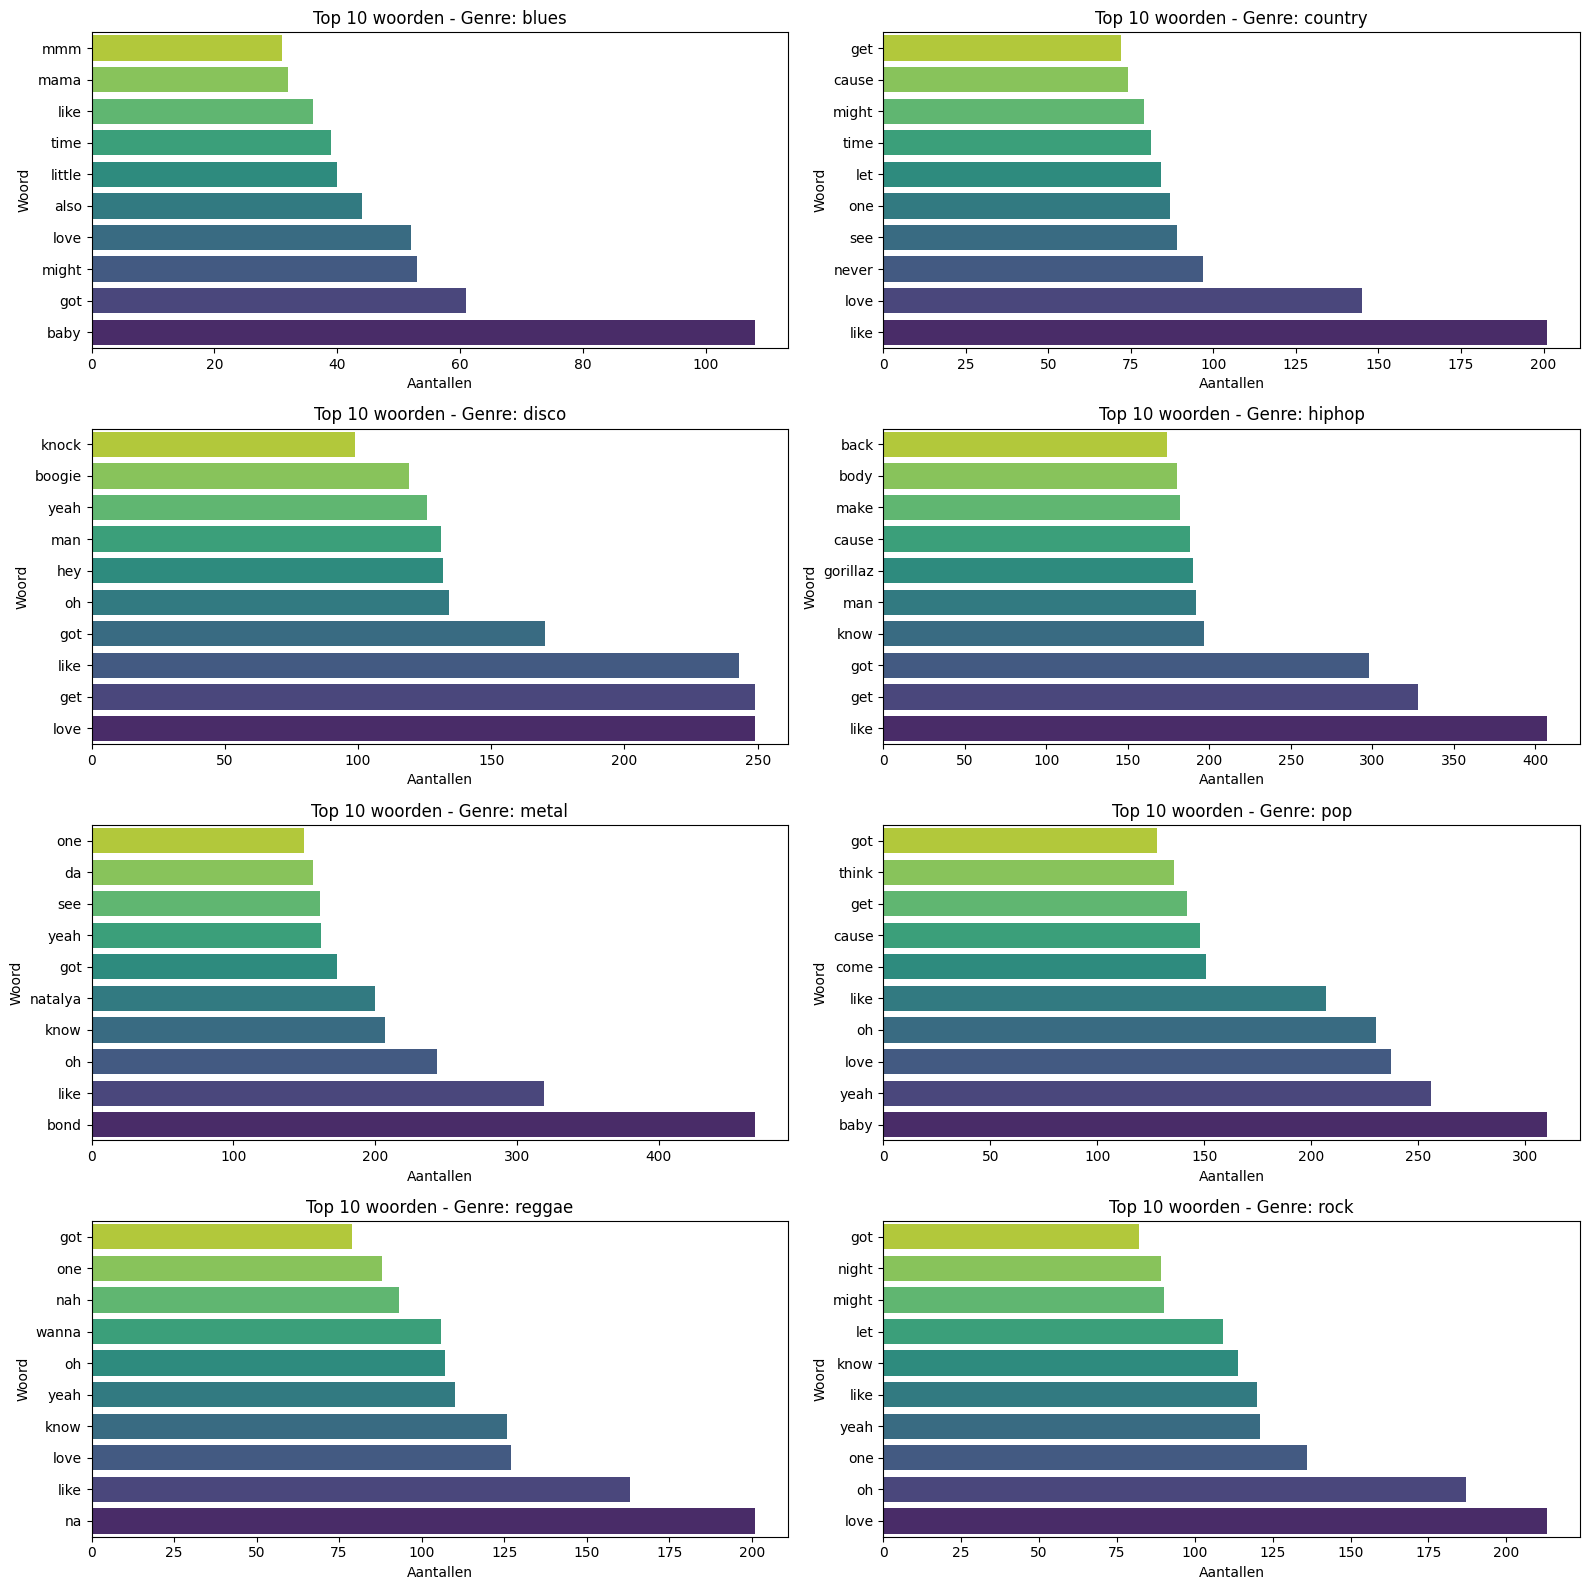

In [ ]:
# Aanmaken van dict voor opslag woorden
top_words_per_genre = {}

for genre, group in grouped:
    # Zorgen voor alleen gevulde tokens en fiteren interpunctie
    all_words = [
        token.translate(translator).strip()
        for tokens in group['tokens']
        for token in tokens
        if token.translate(translator).strip()
        ]

    # Tellen van alle woorden
    word_counts = Counter(all_words)

    # Oppikken van de top_n woorden
    top_words = word_counts.most_common(top_n)

    # Opslaan van de top_n woorden per genre
    top_words_per_genre[genre] = top_words

# Bepalen van aantal genres
num_genres = len(top_words_per_genre)

# Maken van de grafiek
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes = axes.flatten()

# Itereer door de dict
for idx, (genre, top_words) in enumerate(top_words_per_genre.items()):
    # Ophalen van woorden en aantallen
    words, counts = zip(*top_words)

    # Maken van barplot voor aantallen
    sns.barplot(x=counts, y=words, ax=axes[idx], hue=words, palette='viridis')
    axes[idx].set_title(f'Top {top_n} woorden - Genre: {genre}')
    axes[idx].set_xlabel('Aantallen')
    axes[idx].set_ylabel('Woord')
    axes[idx].invert_yaxis()

# Verstoppen van extra assen
for idx in range(len(grouped), len(axes)):
    axes[idx].axis('off')

# Tonen van de plots
plt.tight_layout()
plt.show()

Bij de top 10 woorden per genre zien we al meer verschillen opduiken. De meeste genres hebben een paar woorden die veel voorkomen bij ander genres, maar ook een aantal vrij unieke woorden. Zo heeft metal het woord natalya (hoewel dit waarschijnlijk maar voor een enkel nummer is) en reggae heeft bijvoorbeeld het woord na. Uiteindelijk zijn het deze kenmerken die de modellen leert op te pakken, samen met eventuele verbanden tussen woorden binnen de genres.

[Back to the top](#start)
<a name='2.0'></a>

<div style="background-color:#600170; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H2: LSTM voor audioclips</strong></h2>
</div>


### &sect; 2.1 LSTM voor audioclips
- [ ] LSTM model correct gebouwd (2 punten)
- [ ] Keuze en onderbouwing hyperparameters (6 punten)
- [ ] Modelarchitectuur gevisualiseerd (1 punt)
- [ ] Correcte feature engineering uitgevoerd, en de gemaakte keuzes en ondernomen stappen zijn uitgelegd (4 punten)
- [ ] Uitleg keuze van lossfunctie en optimizer en beschrijving daarvan (4 punten)
- [ ] Juiste data en features gebruikt (1 punt)
- [ ] Model gecompileerd en getraind, keuze van aantal epochs uitgelegd (2 punten)


In [ ]:
# Tonen van de class names
label_names = np.array(train_ds.class_names)

print("label names:", label_names)

In [ ]:
def squeeze(audio, labels=None):
    """
    Squeeze the last dimension of the input tensor.

    Args:
        audio (tf.Tensor): Input tensor with shape (..., N).
        labels (tf.Tensor, optional): Labels tensor. Defaults to None.

    Returns:
        tf.Tensor or tuple: Squeezed input tensor if labels is None, otherwise tuple containing squeezed input tensor and labels tensor.
    """
    audio = tf.squeeze(audio, axis=-1)
    if labels is None:
        return audio
    else:
        return audio, labels

# Gebruik de squeeze-functie met behulp van map op de datasets
train_audio = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_audio = val_ds.map(squeeze, tf.data.AUTOTUNE)
test_audio = test_ds.map(squeeze, tf.data.AUTOTUNE)


In [ ]:
train_ads = train_audio.cache().shuffle(10).prefetch(tf.data.AUTOTUNE)
val_ads = val_audio.cache().prefetch(tf.data.AUTOTUNE)
test_ads = test_audio.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
def get_spectrogram(waveform):
    """
    Convert a waveform tensor into a spectrogram tensor.

    Args:
        waveform (tf.Tensor): Input waveform tensor with shape (..., N).

    Returns:
        tf.Tensor: Spectrogram tensor with shape (..., T, F, 1), where T is the number of time steps and F is the number of frequency bins.
    """
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(waveform, frame_length=512, frame_step=256)

    # Obtain the magnitude of the STFT (use tf.abs).
    spectrogram = tf.abs(spectrogram)

    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]

    return spectrogram


In [ ]:
def make_spec_ds(ds, label=True):
    """
    Create a dataset of spectrograms from a dataset of audio waveforms.

    Args:
        ds (tf.data.Dataset): Input dataset containing audio waveforms.
        label (bool, optional): Whether the dataset contains labels. Defaults to True.

    Returns:
        tf.data.Dataset: Dataset of spectrograms and optional labels.
    """
    if label is True:
        return ds.map(
            map_func=lambda audio, label: (get_spectrogram(audio), label),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    else:
        return ds.map(
            map_func=lambda audio: get_spectrogram(audio),
            num_parallel_calls=tf.data.AUTOTUNE
        )


In [ ]:
train_spectrogram_ds = make_spec_ds(train_ads)
val_spectrogram_ds = make_spec_ds(val_ads)
test_spectrogram_ds = make_spec_ds(test_ads, label=False)

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
def zero_crossing_rate_func(spectrogram, threshold=0.0):
    """
    Bereken de zero crossing rate van een spectrogram.

    Parameters:
    - spectrogram: Een TensorFlow Tensor die een batch van spectrogrammen vertegenwoordigt.
    - threshold: De drempelwaarde om overgangen te detecteren.

    Returns:
    - Een TensorFlow Tensor die de zero crossing rate bevat.
    """
    # Detecteer overgangen door de spectrogram te vergelijken met een drempelwaarde
    crossings = tf.cast(tf.math.less(tf.abs(spectrogram), threshold), tf.float32)

    # Tel het aantal overgangen in elk tijdsvenster
    num_crossings = tf.reduce_sum(crossings, axis=-1)

    # Gemiddelde over de frequentie-as om de zero crossing rate te berekenen
    zcr = num_crossings / tf.cast(tf.shape(spectrogram)[-1], tf.float32)

    return zcr

## **Zero-Crossing Rate (Nuldoorgangsfrequentie)**<a name='Zero-Crossing Rate (Nuldoorgangsfrequentie)'></a>


**Uitleg:**  
De nuldoorgangsfrequentie is een maatstaf voor de hoeveelheid veranderingen in de amplitude van een geluidssignaal over tijd. Het telt het aantal keren dat het signaal van positief naar negatief kruist (of andersom) en geeft daarmee informatie over de mate van fluctuatie in het signaal.

**Formule:**  
De nuldoorgangsfrequentie ($ ZCR $) wordt berekend door het aantal nuldoorgangen te tellen binnen een bepaalde tijdsperiode en vervolgens te delen door de totale lengte van die periode.

**Interpretatie:**  
Een hogere nuldoorgangsfrequentie duidt op een grotere mate van veranderingen in het geluidssignaal, wat kan wijzen op een meer percussief geluid of een geluid met veel hoogfrequente componenten. Een lagere nuldoorgangsfrequentie geeft aan dat het geluid minder veranderingen in amplitude heeft, wat bijvoorbeeld kan wijzen op een geluid met een langzamere verandering in toonhoogte.

**Toepassing:**  
Deze maatstaf wordt vaak gebruikt in spraakherkenning, muziekanalyse en geluidsclassificatie om kenmerken van het geluid te identificeren, zoals ritme, spraakintensiteit, of de aanwezigheid van percussieve elementen.

In [ ]:
def spectral_centroid_func(spectrogram):
    """
    Compute the Spectral Centroid from a spectrogram.

    Parameters:
    - spectrogram: A TensorFlow Tensor representing a batch of spectrograms.

    Returns:
    - A TensorFlow Tensor containing the Spectral Centroid.
    """
    freqs = tf.linspace(0.0, 1.0, spectrogram.shape[-1])
    centroid = tf.reduce_sum(freqs * spectrogram, axis=-1) / (tf.reduce_sum(spectrogram, axis=-1) + 1e-8)
    return centroid

## **Spectraal-Centroid**<a name='spectraal-centroid'></a>

**Uitleg:**  
De spectraal-centroid is een metriek die het gemiddelde frequentiecentrum van een geluidssignaal aangeeft. Het geeft aan waar het "zwaartepunt" van de frequentiedistributie in het spectrum ligt.

**Formule:**  
De spectraal-centroid ($ SC $) wordt berekend met de formule:
$ SC = \frac{\sum_{i=1}^{N} f_i A_i}{\sum_{i=1}^{N} A_i} $

Hierbij staat $ N $ voor het aantal frequentiebanden in het spectrum, $ f_i $ voor de frequentie van de $ i $-de band, en $ A_i $ voor de amplitude van die band.

**Interpretatie:**  
Een hogere waarde van de spectraal-centroid suggereert dat het geluid meer gericht is op hogere frequenties, terwijl een lagere waarde duidt op een nadruk op lagere frequenties. Stel je voor dat je een zwaartepunt hebt op een liniaal, waar hogere frequenties zich aan de rechterkant bevinden en lagere frequenties aan de linkerkant. De spectraal-centroid vertelt je waar dat zwaartepunt op die liniaal zich bevindt.

Toepassing:
Deze maatstaf wordt vaak gebruikt in geluidsverwerking en muziekanalyse om geluiden te karakteriseren op basis van hun timbre of klankkleur.

In [ ]:
def spectrogram_to_mfcc_and_features(spectrograms, num_mel_bins=128, num_coefficients=13, sample_rate=16000):
    """
    Convert a batch of spectrograms to a batch of 1D time series of MFCCs along with additional features.

    Parameters:
    - spectrograms: A TensorFlow Tensor representing a batch of spectrograms with shape (batch_size, 311, 257, 1).
    - num_mel_bins: Number of Mel bins to use.
    - num_coefficients: Number of MFCC coefficients to return.
    - sample_rate: Sample rate of the audio.

    Returns:
    - A TensorFlow Tensor containing the original Mel Spectrogram, Log-Mel Spectrogram, MFCCs,
      MFCCs after applying DCT, Spectral Centroid, Zero Crossing Rate, and Tempo concatenated
      along the last dimension with shape (batch_size, num_frames, num_mel_bins + num_mel_bins +
      num_coefficients * 2 + 3).
    """
    # Remove the last dimension (channel dimension, if it's 1)
    spectrograms = tf.squeeze(spectrograms, axis=-1)

    # Compute Mel spectrograms
    stfts_to_mel_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mel_bins,
        num_spectrogram_bins=spectrograms.shape[-1],
        sample_rate=sample_rate,
        lower_edge_hertz=20.0,
        upper_edge_hertz=sample_rate / 2)
    mel_spectrograms = tf.tensordot(spectrograms, stfts_to_mel_matrix, 1)
    # Shape tuning for the mel spectrograms as expected
    mel_spectrograms.set_shape(spectrograms.shape[:-1] + (num_mel_bins,))

    # Logarithmic scaling for the Mel spectrograms
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_coefficients]

    # Perform DCT on MFCCs
    mfccs_dct = tf.signal.dct(mfccs, type=2, norm='ortho', axis=-1)

    # Compute Spectral Centroid
    spectral_centroid = spectral_centroid_func(mel_spectrograms)
    

    # Compute Zero Crossing Rate
    zero_crossing_rate = zero_crossing_rate_func(spectrograms, threshold=0.0)


    # Concatenate original Mel Spectrogram, Log-Mel Spectrogram, MFCCs, MFCCs after DCT,
    # Spectral Centroid, Zero Crossing Rate
    combined_features = tf.concat([
        mfccs, 
        mfccs_dct,
        tf.expand_dims(spectral_centroid, axis=-1),
        zero_crossing_rate[:, :, tf.newaxis], ], axis=-1)
    return combined_features

## **MFCC's**<a name='mfcc'></a>

Volgens Singh (2021) dienen Mel Frequency Cepstral Coefficients (MFCC's) als een representatie van het spectrum in een audio-signaal. Dit wordt bereikt door het signaal uit te drukken als een som van verschillende sinusgolven. In de onderstaande tekst wordt het process voor de MFCC uitgelegd, de wiskundige informatie is verkregen door gebruik van verschillende bronnen.

Het proces begint met het opdelen van het signaal in korte tijdsframes om veranderingen in frequentie vast te leggen. Dit wordt gedaan om ervoor te zorgen dat de eigenschappen van het geluid in de tijd goed worden weergegeven. Dit staat ook wel bekend als windowing.

   Wiskundige representatie windowing (Wikipedia, 2023):
   $ x(n) = x[n] \cdot w(n) $<br>
   Hierbij is:
   - $x(n)$ het oorspronkelijke signaal
   - $x[n]$ is het gevensterde signaal
   - $w(n)$ is de vensterfunctie.

Vervolgens wordt de Discrete Fourier Transformatie (DFT) toegepast. Dit houdt in dat op elk tijdsframe een FFT wordt uitgevoerd, wat resulteert in een frequentiespectrum. Hiermee krijgt men inzicht in de frequentiecomponenten van het geluid gedurende elk kort tijdsinterval.

   Wiskundige representatie van DFT (Discrete Fourier Transform | Brilliant Math & Science Wiki, n.d.): $ X_k = \sum_{n=0}^{N-1} x_n e^{-\frac{N}{2}\pi i k n} $<br>
   Hierbij is:
   - $X_k$ de DFT coëfficiënt
   - $k$ de frequentie-index
   - $N$ het aantal elementen van de reeks $x_n$
   - $x_n$ vertegenwoordigt de waarden van de reeks op discrete tijdsindices $n$
   - $e$ het natuurlijk logaritme
   - $i$ de imaginaire eenheid

Een volgende stap omvat het gebruik van Mel-gespreide Filterbanken. Deze filterbanken bestaan uit 20-40 driehoekige filters die op een specifieke manier over het frequentiespectrum zijn verdeeld. De filterbanken uiten zich wiskundig als een matrix. Vervolgens wordt elk tijdsframe vermenigvuldigd met de verkregen matrices, en de resulterende coëfficiënten worden opgeteld. Dit geeft een indicatie van de energie in verschillende frequentiebanden.

   Wiskundige representatie:
   $ C_m = \sum_{k=0}^{N-1} \log(|X(k)|) \cdot Filterbank $

Om de gegevens verder te verfijnen, worden logaritmes toegepast op de spectrogramwaarden. Dit resulteert in log-filterbankenergieën, waardoor de representatie van de audio-spectra meer overeenkomt met de menselijke perceptie van geluid.

   Wiskundige representatie:
   $ C_m' = \log(C_m) $

Dit proces resulteert in wat we Mel Frequency Cepstral Coefficients noemen. Deze coëfficiënten vormen een gestructureerde set getallen die een compacte representatie bieden van de spectrale kenmerken van het oorspronkelijke geluidssignaal. In python is het gelukkig mogelijk om deze stappen uit te laten voeren door middel van de librosa library.

## **Discrete Cosine Transform (DCT):**<a name='Discrete Cosine Transform (DCT):'></a>

De DCT is een wiskundige transformatie die een reeks reële getallen omzet in een reeks cosinuscomponenten met verschillende frequenties. Het wordt vaak gebruikt in signaalverwerking en datacompressie.

In het geval van MFCC's wordt de DCT toegepast op de logaritmische energiewaarden van de mel-filterbankuitvoer om een compactere representatie te verkrijgen die de belangrijkste eigenschappen van het geluidsspectrum behoudt.
Een belangrijk aspect van de DCT is dat het de meeste informatie van het originele signaal behoudt in de eerste paar coëfficiënten, waardoor de rest van de coëfficiënten vaak worden weggelaten voor dimensionale reductie.

**Samenvoeging van MFCC's en DCT:**
De DCT van de MFCC's helpt bij het verminderen van de redundantie in de representatie van het geluidsspectrum, waardoor een compacter en efficiënter kenmerk wordt verkregen dat nog steeds de belangrijke informatie over het geluid behoudt. Deze compacte representatie is gemakkelijker te verwerken in verdere stappen van spraakherkenning of geluidsclassificatiealgoritmen.

In [ ]:
from keras.layers import LSTM, Dropout, Dense, BatchNormalization
from keras.models import Sequential

model = Sequential([
    LSTM(96, return_sequences=True),
    Dropout(0.2)
    LSTM(96),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(8, activation='softmax')
])

from keras.optimizers import Adam


optimizer = Adam(learning_rate=0.001)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

**Beste parameters**  
Met behulp van een keras tuner kwamen deze waardes eruit.  
Trial 10 Complete [00h 05m 17s]  
val_accuracy: 0.38317757844924927  

Best val_accuracy So Far: 0.4392523467540741  
Total elapsed time: 00h 48m 35s  
Beste LSTM units: 96  
Beste Dense units: 128  
Beste dropout rate: 0.2  
Beste learning rate: 0.001  

**Lossfunctie:**

De lossfunctie evalueert hoe goed het model presteert op een set trainingsgegevens door de afstand tussen de voorspelde uitvoer van het model en de werkelijke uitvoer te meten. Het doel is om deze afstand te minimaliseren tijdens het trainen van het model.

Categorische cross-entropy (sparse_categorical_crossentropy): Dit is een veelgebruikte lossfunctie voor classificatietaken waarbij de uitvoer meerdere klassen heeft. Het berekent de cross-entropy tussen de werkelijke labels en de voorspelde waarschijnlijkheden van elk voorbeeld. Met deze lossfunctie worden de voorspellingen vergeleken met discrete labels (zoals 0, 1, 2) zonder dat ze worden omgezet naar one-hot encoding.

**Optimizer:**

De optimizer bepaalt hoe de parameters van het model worden aangepast tijdens het trainen om de lossfunctie te minimaliseren. Het beïnvloedt de snelheid en stabiliteit van het leerproces.

Adam optimizer: Adam staat voor "Adaptive Moment Estimation". Het is een populaire optimizer die adaptieve learning rates gebruikt voor elke parameter van het model. Het past de learning rate dynamisch aan voor elke parameter op basis van schattingen van de eerste en tweede momenten van de gradiënt. Dit maakt het een robuuste en efficiënte optimizer voor veel taken.
Door gebruik te maken van sparse_categorical_crossentropy lossfunctie en de Adam optimizer voor je classificatiemodel, ben je goed uitgerust om te trainen met efficiënte en robuuste algoritmen die in de praktijk vaak goede resultaten opleveren. Deze combinatie is een goede keuze voor veel classificatietaken, maar het is altijd aan te raden om te experimenteren met verschillende lossfuncties en optimizers om te zien welke het beste werkt voor jouw specifieke probleem.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = best_model.fit(
    train_MFCC_ds,
    validation_data=val_MFCC_ds,
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping]
)


In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

[Back to the top](#start)
<a name='2.2'></a>
<h3>&sect;2.2:</h3>



[Back to the top](#start)
<a name='3.0'></a>

<div style="background-color:#600170; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H3: LSTM voor songteksten</strong></h2>
</div>

### &sect;3.1: LSTM voor songteksten
- [ ] Tekst-LSTM model correct gebouwd (2 punten)
- [ ] Keuze en onderbouwing hyperparameters (6 punten)
- [ ] Correcte tekstprocessing, feature-engineering en data-augmentatie toegepast en uitgelegd (4 punten)
- [ ] Modelarchitectuur gevisualiseerd (1 punt)
- [ ] Juiste data en features gebruikt (1 punt)
- [ ] Een geschikte woordembedding (pretrained of from-scratch getraind) gebruikt en uitgelegd (4 punten)
- [ ] Model gecompileerd en getraind, keuze van aantal epochs uitgelegd (2 punten)



**preprocessing**

Dit is een Python-functie genaamd **clean_tf_text** Deze functie is handig voor het voorbereiden van tekstuele gegevens voor verwerking door een TensorFlow-model voor tekstclassificatie. Het kan helpen bij het normaliseren van de tekst en het verwijderen van ongewenste tekens, waardoor het model beter kan presteren.

In [ ]:

def clean_tf_text(text):
    # Remove escaped characters such as '\', 'n', etc.
    text = tf.strings.regex_replace(text, r'\\[^\s]+', ' ')

    # Remove non-ASCII characters
    text = tf.strings.regex_replace(text, r'[^\x00-\x7F]+', ' ')

    # Remove square brackets and their contents
    text = tf.strings.regex_replace(text, r'\[.*?\]', '')

    # Remove parentheses and their contents
    text = tf.strings.regex_replace(text, r'\(.*?\)', '')

    # Remove leading and trailing whitespace
    text = tf.strings.strip(text)

    # Remove any extra whitespace
    text = tf.strings.regex_replace(text, r'\s+', ' ')

    # Replace 'lyrics' with space
    text = tf.strings.regex_replace(text, 'lyrics', ' ')

    # Convert to lowercase
    text = tf.strings.lower(text)

    text = tf.strings.regex_replace(text, r"\\", "")

    return text

cleaned_tf_text = clean_tf_text(train_data['lyrics'])
print(cleaned_tf_text)

tf.Tensor(
[b"i m in the mood lyrics i'm in the mood, baby, i'm in the mood for love i'm in the mood, baby, i'm in the mood for love i'm in the mood, i'm in the mood baby, i'm in the mood for love i said night time is the right time, to be with the one you love you know when night come, baby, god know you so far away i'm in the mood i'm in the mood, baby, i'm in the mood for love i'm in the mood, in the mood baby, in the mood for love i said yes, my mama told me to leave that girl alone but my mama didn't know, god know, girl was puttin' down i'm in the mood i'm in the mood, baby, the mood for love i'm in the mood, i'm in the mood baby, in the mood for loveyou might also likeembed"
 b"think twice before you go, baby, this will be the end think twice before you go, baby, this will be the end you done leave me one time, baby you'll leave again dig in and suffer with me, an' i know you paid your dues dig in and suffer with me baby, an' i know you paid your dues you done leave me when i ne

**vectorization layer**

Een TextVectorization-layer wordt gebruikt voor het voorverwerken van tekstuele gegevens voordat ze worden ingevoerd in een neuraal netwerkmodel. Het biedt een gestandaardiseerde manier om tekst om te zetten in numerieke representaties die kunnen worden begrepen door neurale netwerken.

In [ ]:
# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 100

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=clean_tf_text,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)



lyrics = np.array(train_data['lyrics'])
vectorize_layer.adapt(lyrics)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(train_data['genre'])


genres = to_categorical(encoded_labels)

# Split the data into features (lyrics) and target (genre)
X = lyrics
y = genres

# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


**Embedding layer**

De numerieke representaties van de tekst, verkregen uit de TextVectorization-layer, worden vervolgens ingevoerd in de Embedding-layer. Deze laag leert de optimale dichte representaties (embeddings) voor elk woord tijdens het trainen van het model. Deze embeddings bevatten informatie over de woorden en worden gebruikt als invoer voor verdere lagen in het neurale netwerk.

In [ ]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization

embedding_dim = 256
lstm_units = 128
dropout_rate = 0.1


lstm_lyrics = Sequential([
    vectorize_layer,
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    BatchNormalization(),
    Bidirectional(LSTM(lstm_units, return_sequences=True)),  # Using return_sequences for stacking
    BatchNormalization(),
    Bidirectional(LSTM(lstm_units)),  # Second LSTM layer
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(8, activation='softmax')
])
lstm_lyrics.build()
lstm_lyrics.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
plot_model(lstm_lyrics)

**Beste parameters**
Met behulp van een keras tuner kwamen deze waardes eruit.\
Trial 10 Complete [00h 00m 08s] \
val_accuracy: 0.24074074625968933 

Best val_accuracy So Far: 0.3333333432674408 \
Total elapsed time: 00h 01m 14s \
Beste LSTM units: 128   \
Beste Dense units: 64   \
Beste BatchNormalization layers: 3 \
Beste learning rate: 0.001  

**EarlyStopping**

Om de juiste hoeveelheid epochs te bepalen en overfitting te voorkomen maken we gebruik van Earlystopping

**Optimizer** 

Adam heeft zich in de praktijk bewezen als een robuust en effectief optimalisatie-algoritme voor een breed scala aan taken, waaronder multiclass-classificatie.
Daarnaast werkt Adam goed met grote datasets en modellen met veel parameters, wat vaak het geval is bij multiclass-classificatieproblemen waarbij meerdere klassen moeten worden onderscheiden.

**Lossfunctie**
Over het algemeen is categorical_crossentropy geschikt voor multiclass-classificatieproblemen waarbij de klassen niet overlappend zijn en elke invoer slechts tot één klasse behoort. 

In [ ]:

# Compile the model
lstm_lyrics.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

stop_early = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

# Train the model
history = lstm_lyrics.fit(X_train, y_train, epochs=400, batch_size=8,validation_data=(X_val,y_val),callbacks=[stop_early])

Epoch 1/400
54/54 [==============================] - 9s 43ms/step - loss: 2.2836 - accuracy: 0.2145 - val_loss: 2.0680 - val_accuracy: 0.1481
Epoch 2/400
54/54 [==============================] - 1s 26ms/step - loss: 0.4947 - accuracy: 0.8811 - val_loss: 2.0465 - val_accuracy: 0.2593
Epoch 3/400
54/54 [==============================] - 2s 28ms/step - loss: 0.1255 - accuracy: 0.9977 - val_loss: 2.0075 - val_accuracy: 0.2685
Epoch 4/400
54/54 [==============================] - 1s 26ms/step - loss: 0.0531 - accuracy: 1.0000 - val_loss: 1.9490 - val_accuracy: 0.2778
Epoch 5/400
54/54 [==============================] - 1s 28ms/step - loss: 0.0287 - accuracy: 1.0000 - val_loss: 1.9009 - val_accuracy: 0.2963
Epoch 6/400
54/54 [==============================] - 1s 27ms/step - loss: 0.0225 - accuracy: 1.0000 - val_loss: 1.8886 - val_accuracy: 0.3056
Epoch 7/400
54/54 [==============================] - 1s 25ms/step - loss: 0.0186 - accuracy: 1.0000 - val_loss: 1.9692 - val_accuracy: 0.3241
Epoch 

[Back to the top](#start)
<a name='4.0'></a>

<div style="background-color:#600170; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H4: Transformer voor songteksten</strong></h2>
</div>

Een transformer is een type model dat is gespecialiseerd om tekst, audio of beeldgegevens te verwerken. Modellen als chatGPT, de Bing Image Creator en het model achter Suno zijn voorbeelden van hoe tekst kan worden omgezet naar nieuwe producten. In dit notebook zal er een transformer worden gebruikt om te zorgen dat de lyrics worden geanalyseerd en dat het model kan voorspellen tot welke genre het nummer hoort. De kern van deze transformer zal komen van de website [Hugging Face](https://huggingface.co/models), een platform waar veel verschillende modellen op worden gedeeld.

BERT (Bidirectional Encoder Representations from Transformers) is een transformer-gebaseerd taalmodel ontwikkeld door Google. Het model heeft voor gezorgd voor grootte veranderingen op NLP gebied door de unieke aanpak en de prestaties van het model. In dit notebook is gekozen om te werken met een variant ven BERT, genaamd [DistilBert-base-uncased model](https://huggingface.co/distilbert/distilbert-base-uncased). DistilBERT, zoals de naam al impliceerd, is de gedistileerde versie van BERT. Deze distilatie zorgt voor minder parameters, waardoor het model sneller is en minder rekenkracht vereist. DistilBERT heeft ook een vergelijkbare prestatie ten opzichte van BERT, wat het een betere keuze maakt voor minder krachtige apparatuur. Dit ziet er op de volgende manier uit:

![DistilBERT](distilbert.png)

Daarnaast is DistilBERT in staat om effectief en efficient om te gaan met de songteksten. Omdat het model beschikt over een goed begrip van context, is het model in staat om eventuele context gerelateerde onderscheidingen binnen de lyrics van verschillende genres te kunnen maken.

<a name='4.1'></a>
<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:30px; font-weight:bold;">&sect;4.1: Aanmaken van de juiste datasets</div>
</div>
<br>

Om DistilBERT te kunnen gebruiken moeten er nog een paar aanpassingen worden gemaakt aan de dataset. De eerste aanpassing is het splitsen van de trainings data in een train en een validatie set. Om te zorgen dat elk genre goed is gerepresenteerd in de data is er gekozen om hier een vast aantal rijen per genre voor te selecteren. Op deze manier is er duidelijke representatie in zowel de trainings als de validatie data. Voordat de splitsing plaatsvind zal de data worden opgeschoond.

In [11]:
# Toepassen van clean_text op de data
train_data['cleaned_lyrics'] = clean_text(train_data['lyrics'], stopword=False)
test_data['cleaned_lyrics'] = clean_text(test_data['lyrics'], stopword=False)

# Ophalen van unieke genres
uni_genres = train_data['genre'].unique()

# Maken van een list voor het selecteren van de data
validation = []

# Selecteren van 6 liederen per genre
for genre in uni_genres:
    # Filtreer de data op het huidige genre
    genre_data = train_data[train_data['genre'] == genre]

    # Pak de index van 6 samples uit de rijen
    samples = genre_data.sample(n=6, random_state=42).index

    # Voeg de samples toe aan de validatie lijst
    validation.extend(samples)

# Aanmaken van de validatie data door index-based selection
val_data = train_data.loc[validation]

# Aanmaken van de train data door index-based dropping
train_data = train_data.drop(validation)

Nu de data is gesplitst is het tijd om de tokenizer van DistilBERT aan te maken. Deze tokenizer helpt ons om de data om te zetten naar hetzelfde format dat is gebruikt tijdens de training van DistilBERT. Ook zal er een label encoder worden aangemaakt om de genres om te zetten in integers.

In [12]:
# Klaarzetten van distilbert
checkpoint = 'distilbert-base-uncased'

# Aanmaken van tokenizer en LabelEncoder
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
label_encoder = LabelEncoder()

Met behulp van deze tools kunnen de lyrics en de genres worden omgezet tot begrijpelijke getallen, waarmee het model in staat is om de tekst te begrijpen. Om dit eenvoudig te kunnen herhalen is de `tokenize()` functie aangemaakt.

In [13]:
def tokenize(df, text_col, label_col=None):
    """
    Deze functie bereid de tekstdata en genres voor, zodat
    deze geldige waarden hebben voor in het model.

    Parameters:
    ----------
    df : pd.DataFrame
        Het dataframe dat de tekst bevat

    text_col : str
        De naam van de kolom die de teksten bevat

    label_col : str, optional (Default=None)
        De naam van de kolom met de labels

    Returns:
    ----------
    tokenized_df : pd.DataFrame
        Het dataframe met de tokenized teksten
    """
    # Ophalen tekst data
    text_data = df[text_col].tolist()

    # Tokenize de data
    tokenized_output = tokenizer(
        text_data,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='tf'
    )

    # Aanmaken van nieuw dataframe met tokens
    tokenized_df = pd.DataFrame({
        'input_ids': list(tokenized_output['input_ids']),
        'attention_mask': list(tokenized_output['attention_mask'])
    })

    if label_col:
        # Transformeren van de labels naar int
        labels = label_encoder.fit_transform(df[label_col])
        tokenized_df['labels'] = list(labels)

    return tokenized_df

Met deze functie is het simpel om alle dataframes om te zetten naar dataframes met tokens.

In [18]:
# Aanmaken van token datasets
token_train = tokenize(train_data, 'cleaned_lyrics', 'genre')
token_val = tokenize(val_data, 'cleaned_lyrics', 'genre')
token_test = tokenize(test_data, 'cleaned_lyrics')

Voordat de vervolgstappen genomen kunnen worden is het belangrijk om te kijken of alle stappen goed zijn ondernomen.

In [19]:
# Kijken naar de data shapes
print("Shape van de input_ids en attention_mask:")
print(token_train['input_ids'][0].shape)
print(token_train['attention_mask'][0].shape)

# Kijken naar de labels
print("Labels train set t.o.v. token_train labels:")
display(token_train['labels'].value_counts())
display(train_data['genre'].value_counts())

Shape van de input_ids en attention_mask:
(512,)
(512,)
Labels train set t.o.v. token_train labels:


labels
7    73
3    67
5    67
1    66
2    62
4    58
6    58
0    38
Name: count, dtype: int64

genre
rock       73
hiphop     67
pop        67
country    66
disco      62
metal      58
reggae     58
blues      38
Name: count, dtype: int64

De shapes komen overeen met wat er verwacht wordt voor het model, ook de labels zijn goed gesplitst. Nu zullen de labels in een lijst worden gezet om later de voorspellingen te kunnen uploaden naar Kaggle.

In [20]:
genre_list = [
    'blues', 'country', 'disco', 'hiphop',
    'metal', 'pop', 'reggae', 'rock'
    ]

Nu de labels zijn opgeslagen kan er door worden gegaan naar de volgende stap, het omzetten van de data naar een tensor. Door middel van de zelf gedefineerde functie `convert_to_tf_dataset()` is het makkelijk om alle drie de datasets om te zetten.

In [21]:
def convert_to_tf_dataset(df, feature_cols, label_col=None, shuffle=True, batch_size=16):
    """
    Deze functie zet een dataframe om tot een
    tensorflow dataset.

    Parameters:
    ----------
    df : pd.DataFrame
        Het dataframe dat wordt omgezet tot tf dataset

    feature_cols : list
        Een list met alle kolomnamen van de features

    label_col : str, optional (Default=None)
        De kolomnaam van de label kolom

    shuffle : bool, optional (Default=True)
        Geeft aan of de data geshuffeld moet worden

    batch_size : int, optional (Default=16)
        Het aantal rijen in een batch

    Returns:
    ----------
    dataset : pd.DataFrame
        De TF dataset die is gebaseerd op het dataframe
    """
    # Ophalen van features en labels
    features = {col: df[col].tolist() for col in feature_cols}
    if label_col:
        labels = df[label_col].tolist()

    # Omzetten naar tensorflow dataset
    if label_col:
        dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    else:
        dataset = tf.data.Dataset.from_tensor_slices(features)

    # Shuffle de dataset indien nodig
    if shuffle is True:
        dataset = dataset.shuffle(buffer_size=len(df))

    # Batch de data
    dataset = dataset.batch(batch_size)

    return dataset

Nu de functie is gebouwd kunnen de nodige parameters aangemaakt worden. Daarna kunnen de datasets worden omgezet.

In [22]:
# Aanmaken van de kolom features
feature_cols = ['input_ids', 'attention_mask']
label_col = 'labels'

# Transformeren van de dataframes naar TF datasets
train_dataset = convert_to_tf_dataset(token_train, feature_cols, label_col)
val_dataset = convert_to_tf_dataset(token_val, feature_cols, label_col)
test_dataset = convert_to_tf_dataset(token_test, feature_cols, shuffle=False)

Voordat er vervolgstappen worden genomen zal de data snel worden bekeken. Omdat de data in tensors is opgeslagen moet dit gebeuren door te loopen over de dataset. Op deze manier kan er in een batch van de data worden gekeken.

In [25]:
# Bekijken van een batch in de train dataset
for batch in train_dataset:
  # Splitten van de features en de labels
  features, labels = batch

  # Bekijken van de shapes
  print("Data shapes:")
  print(f"Input_ids: {features['input_ids'].shape}")
  print(f"Attention_mask: {features['attention_mask'].shape}")
  print(f"Labels: {labels.shape}")

  # Bekijken of de shuffle succesvol is geweest
  print("Labels:")
  print(labels.numpy)

  # Break de loop na 1 iteratie
  break

Data shapes:
Input_ids: (16, 512)
Attention_mask: (16, 512)
Labels: (16,)
Labels:
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(16,), dtype=int32, numpy=array([2, 7, 1, 5, 1, 7, 2, 4, 7, 7, 3, 7, 2, 3, 2, 3], dtype=int32)>>


<a name='4.2'></a>
<div style="background-color:#600170; color:#fff; padding:10px; border-radius:5px; display: flex; justify-content: center; align-items: center; position: relative;">
    <div style="font-size:30px; font-weight:bold;">&sect;4.2: Aanmaken en fine-tuning van het model</div>
</div>
<br>

Nu de data op de juiste wijze klaar staat, kan het model gemaakt worden. Om het model te maken kan de de code van HuggingFace worden gebruikt. Deze simpele code laat ons een model inladen van de HuggingFace website inladen, met een eigen keuze voor het aantal labels.

In [30]:
# Gebruik van TFAutoModel
transformer = TFAutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=8
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Nu kan het model gecompiled worden. Tijdens deze stap zal er ook gebruik worden gemaakt van een Learning Rate Scheduler. Deze techniek zorgt ervoor dat de learning rate, gedurende het trainingsproces, als maar lager zal worden. Op deze manier kan de transformer goed leren en zich aanpassen aan de nieuwe data.

In [31]:
# Het aantal epochs
num_epochs = 100

# Het aantal training stappen
num_train_steps = len(train_dataset) * num_epochs

# Maken van een LearningRate-scheduler
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

# Aanmaken van de optimizer met de LR-scheduler
optimizer = Adam(
    learning_rate=lr_scheduler
)

# Maken van de loss door tf.keras.losses
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compilen van het model
transformer.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)

Na het compilen kan het model worden gefit. Er is gekozen voor 100 epochs met een callback die overfitting na 5 epochs tegen gaat.

In [32]:
# Aanmaken van EarlyStopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

# Fitten van het model met de data
history = transformer.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[early_stop]
)

Epoch 1/100
31/31 [==============================] - 62s 1s/step - loss: 1.9991 - accuracy: 0.2270 - val_loss: 1.8904 - val_accuracy: 0.3333
Epoch 2/100
31/31 [==============================] - 28s 919ms/step - loss: 1.5466 - accuracy: 0.5194 - val_loss: 1.6060 - val_accuracy: 0.3958
Epoch 3/100
31/31 [==============================] - 28s 911ms/step - loss: 0.9737 - accuracy: 0.7464 - val_loss: 1.5454 - val_accuracy: 0.4792
Epoch 4/100
31/31 [==============================] - 28s 912ms/step - loss: 0.5055 - accuracy: 0.9039 - val_loss: 1.3995 - val_accuracy: 0.5417
Epoch 5/100
31/31 [==============================] - 28s 915ms/step - loss: 0.2895 - accuracy: 0.9448 - val_loss: 1.4854 - val_accuracy: 0.5625
Epoch 6/100
31/31 [==============================] - 28s 917ms/step - loss: 0.1302 - accuracy: 0.9857 - val_loss: 1.4760 - val_accuracy: 0.6042
Epoch 7/100
31/31 [==============================] - 29s 924ms/step - loss: 0.0644 - accuracy: 0.9980 - val_loss: 1.6339 - val_accuracy: 0.

Nu het model is getrained kunnen er voorspellingen worden gemaakt en kan het verloop van de loss worden gevisualiseerd.

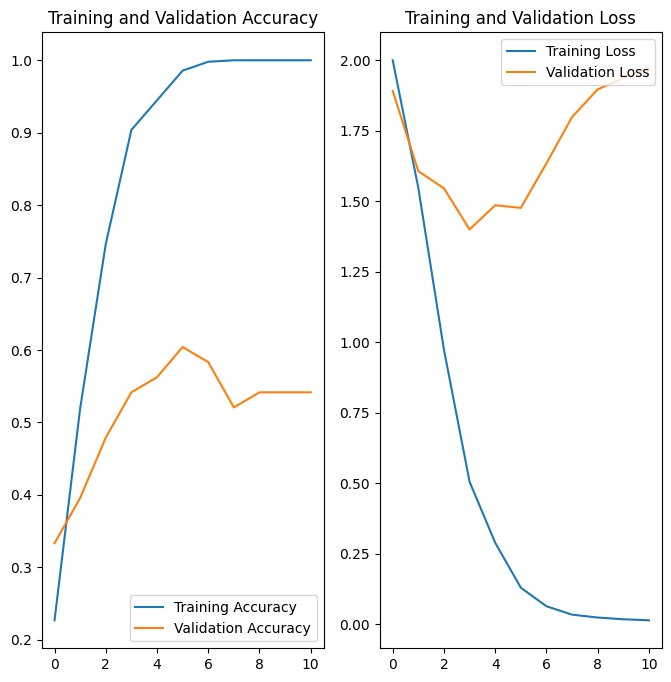

In [33]:
# Ophalen van accuracy en loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Krijgen aantal epochs
epochs_range = range(early_stop.stopped_epoch + 1) if early_stop.stopped_epoch > 0 else range(num_epochs)

# Plotten van de grafiek
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Rond epoch 4/5 is het model begonnen met overfitten op de trainings data. Gelukkig zorgt early stopping ervoor dat het model nu terug is gezet naar het moment voordat het ging overfitten. Met dit model kunnen we voorspellingen aanmaken.

In [34]:
# Voorspellen met het model
pred = transformer.predict(val_dataset)

# Tonen van de voorspellingen
print("Voorspellingen:")
print(np.argmax(pred.logits, axis=1))

3/3 [==============================] - 5s 296ms/step
Voorspellingen:
[7 7 2 4 2 3 7 0 6 3 6 5 3 5 2 2 0 1 3 5 5 2 4 7 7 3 4 1 5 1 1 6 2 2 7 2 4
 0 1 2 3 6 6 2 7 2 4 1]


Na de voorspellingen is het alleen nog nodig om de voorspellingen naar Kaggle te uploaden. Tegelijkertijd wordt ook het model opgeslagen.

In [37]:
# Opslaan van het model
transformer.save("Transformer", save_format="tf")

# Aanmaken van csv bestand
kaggle_csv(
    transformer, test_dataset,
    genre_list, "Transformer"
)

9/9 [==============================] - 2s 264ms/step
voorspelling_Transformer_0502160849.csv has been saved!


[Back to the top](#start)
<a name='5.0'></a>

<div style="background-color:#600170; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H5: Model naar keuze</strong></h2>
</div>

### &sect;5.1: Model naar keuze
- [ ] Model correct gebouwd en alle keuzes gedetailleerd uitgelegd (5 punten)
- [ ] Keuze en onderbouwing hyperparameters (10 punten)
- [ ] Modelarchitectuur gevisualiseerd (1 punt)
- [ ] Juiste data gebruikt (2 punten)
- [ ] Model gecompileerd en getraind, keuze van aantal epochs uitgelegd (2 punten)


In [11]:
# Loop door alle mappen in train_dir
file_list = []
genre_list = []
test_list = []

for map in os.listdir(train_dir):  
    # Maak het pad naar de huidige map
    current_map_path = os.path.join(train_dir, map)
    
    # Loop door alle bestanden in de huidige map
    for file in os.listdir(current_map_path):
        file_list.append(os.path.join(current_map_path, file))
        genre_list.append(str(map))

for file in os.listdir(test_dir):  
    test_list.append(os.path.join(test_dir, file))

In [12]:
def process_audio_files(file_list, seconds=30, sample_frequency=22050):
    """
    Process audio files by truncating or padding them to a specified length.

    Parameters:
    - file_list (list): A list of file paths to audio files.
    - seconds (int): The target length (in seconds) of the audio clip (default is 30 seconds).
    - sample_frequency (int): The sample frequency of the audio files (default is 22050 Hz).

    Returns:
    - audio_data (ndarray): A numpy array containing the processed audio data.
    - sample_freqs (ndarray): A numpy array containing the sample frequencies of the processed audio data.
    """
    # Target lengte instellen van de audio clip
    target_length = sample_frequency * seconds

    # Lists voor audio data
    audio_data = []
    sample_freqs = []

    # Process elke audio file 
    for file in file_list:
        if file.endswith(".wav"):
            data, sfreq = lr.load(file, sr=None) 

            # Truncate or pad the audio
            if len(data) > target_length:
                # Truncate the data
                data = data[:target_length]
            elif len(data) < target_length:
                # Pad with zeros
                padding = target_length - len(data)
                data = np.pad(data, (0, padding), mode='constant')

            # Append de data
            audio_data.append(data)
            sample_freqs.append(sfreq)

    # Omzetten naar een numpy array
    audio_data = np.stack(audio_data, axis=0)
    sample_freqs = np.array(sample_freqs)

    return audio_data, sample_freqs

def create_mfcc(audio, sfreq):
    """
    Create Mel-frequency cepstral coefficients (MFCCs) from audio data.

    Parameters:
    - audio (ndarray): Numpy array containing the audio data.
    - sfreq (ndarray): Numpy array containing the sample frequencies of the audio data.

    Returns:
    - mfccs (ndarray): Numpy array containing the MFCCs of the audio data.
    """
    mfccs_list = []
    
    for a, s in zip(audio, sfreq):
        mfcc = lr.feature.mfcc(y=a, sr=s)
        mfccs_list.append(mfcc)
    
    mfccs = np.array(mfccs_list)
    mfccs = mfccs[..., np.newaxis]
    return mfccs

In [21]:
audio, sfreq = process_audio_files(file_list)
X = create_mfcc(audio, sfreq)

audio_test, sfreq_test = process_audio_files(test_list)
test = create_mfcc(audio_test, sfreq_test)

Voor ons model naar keuze hebben wij gekozen voor een CNN model. Wij zijn op dit idee gekomen nadat we spectogrammen hadden gevisualiseerd. Bij de cel hieronder hebben wij een willekeurig audio bestand gevisualiseerd. Wij kwamen er achter dat we zelf al met het blote oog genres goed konden voorspellen door naar de spectogrammen te kijken. Als mensen het kunnen dan zou het een CNN model ook wel moet lukken om goede voorspellingen te maken. Als input voor ons model hebben wij niet letterlijk de spectogrammen gebruik maar mfcc. Hoe mfcc werkt bij hoofdstuk 2 uitgelegd.

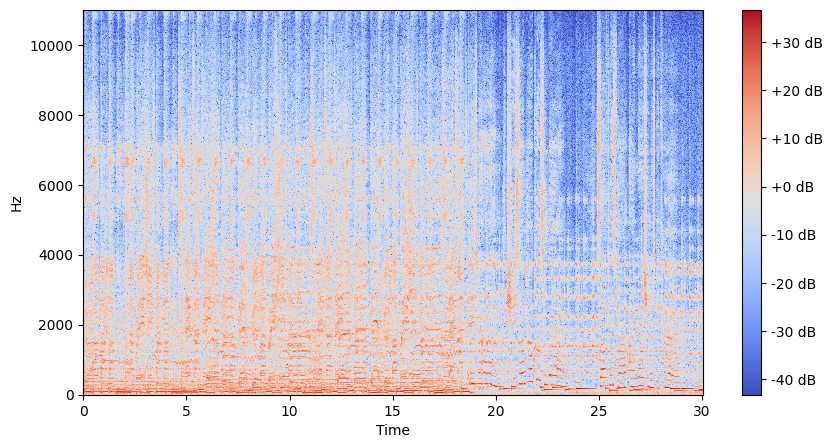

In [24]:
import random

random = random_index = random.randint(0, len(audio) - 1)

stft = lr.stft(audio[random])
spec = np.abs(stft)
spec_db = amplitude_to_db(spec)

plt.figure(figsize=(10, 5))
img = specshow(spec_db, x_axis='time', y_axis='hz', sr=22000, hop_length=512)
plt.colorbar(img, format='%+2.0f dB')
plt.show()

# Play the clip
Audio(data=audio[random], rate=sfreq[random])


In [26]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(genre_list)
y_encoded = to_categorical(encoded_labels)

X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded,random_state=42)
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])


In [33]:
model = Sequential()
model.add(Conv2D(128, (3, 3), activation = "relu", input_shape = input_shape))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation = "relu"))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(8, activation="softmax"))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 18, 1290, 128)       │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 645, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 9, 645, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 643, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 322, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 4, 322, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 321, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 161, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 2, 161, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 10304)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,319,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,486,504 (5.67 MB)

 Trainable params: 1,485,928 (5.67 MB)

 Non-trainable params: 576 (2.25 KB)

Wij zij uiteindelijk op dit model uitgekomen door een hoop opties te proberen. Wij hebben meerderen versies van dit model gemaak met bijvoorbeeld meer of minder conv2d lagen. Wij hebben bij elk model de hyperparameters geoptimaliseerd met de bovenstaande model als ons beste resultaat. 


In [ ]:
optimizer = Adam(learning_rate = 0.001)

model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

checkpoint_path = "model.weights.keras"  # Adjusted file path
checkpoint_callback = ModelCheckpoint(checkpoint_path, save_weights_only=False, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data = (X_val, y_val), callbacks=[checkpoint_callback])


Voor het trainen hebben wij voor 25 epochs gekozen, omdat het model rond epoch 20 zijn maximum heeft bereikt. Doordat wij gebruik maken van checkpoint_callback is het niet erg dat de model een paar epochs door gaat met trainen, omdat wij dan de epoch met de hoogste val_accuracy terugkrijgen.

In [ ]:
best_model = load_model(checkpoint_path)

y_pred = best_model.predict(test)


class_labels = label_encoder.classes_
predicted_indices = np.argmax(y_pred, axis=1)
y_pred_class = [class_labels[i] for i in predicted_indices]

print(y_pred_class)

Hier onder gebruiken wij de antwoorden van kaggle om te testen hoe goed ons model is.

In [ ]:
ant = ['rock', 'country', 'pop', 'metal', 'disco', 'reggae', 'pop', 'rock', 'pop', 'hiphop', 'pop', 'hiphop', 'pop', 'blues', 'reggae', 'hiphop', 'pop', 'disco', 'blues', 'rock', 'country', 'reggae', 'hiphop', 'metal', 'disco', 'country', 'metal', 'disco', 'hiphop', 'rock', 'metal', 'pop', 'rock', 'rock', 'pop', 'country', 'hiphop', 'hiphop', 'blues', 'blues', 'country', 'country', 'disco', 'reggae', 'disco', 'blues', 'rock', 'blues', 'reggae', 'country', 'reggae', 'disco', 'pop', 'reggae', 'rock', 'hiphop', 'metal', 'blues', 'metal', 'pop', 'metal', 'rock', 'metal', 'metal', 'rock', 'reggae', 'rock', 'pop', 'reggae', 'country', 'blues', 'metal', 'disco', 'blues', 'disco', 'country', 'reggae', 'metal', 'pop', 'pop', 'hiphop', 'pop', 'hiphop', 'rock', 'country', 'hiphop', 'rock', 'pop', 'rock', 'metal', 'metal', 'hiphop', 'reggae', 'metal', 'blues', 'hiphop', 'hiphop', 'country', 'country', 'reggae', 'rock', 'hiphop', 'disco', 'reggae', 'disco', 'metal', 'country', 'disco', 'pop', 'country', 'hiphop', 'reggae', 'rock', 'disco', 'disco', 'hiphop', 'rock', 'country', 'hiphop', 'rock', 'pop', 'rock', 'pop', 'reggae', 'disco', 'country', 'disco', 'reggae', 'country']
accuracy = accuracy_score(ant, y_pred_class)

print("Accuracy:", accuracy)

Ons beste score kwam uit op 57% accuracy

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

[Back to the top](#findings)
<a name='6.0'></a>

<div style="background-color:#600170; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H6: Bevindingen</strong></h2>
</div>

### &sect;6.1: Bevindingen
In het notebook zijn er uiteindelijk zo'n 8 volledige modellen getraint en getest. De modellen gaven de volgende resultaten:

|Model|Accuracy Train|Accuracy Validatie
|--|--|--
|LSTM - Audio|0.7843|0.4140
|LSTM - Tekst|1.0000 |0.3346
|Transformer|0.9857|0.6042
|Keuze Model|1.000|0.57

Naast dat de modellen in het notebook zijn getest op de validatieset, zijn de modellen ook getest op de testset. Om de scores van de testset te kunnen bekijken is het nodig om de voorspellingen up te loaden naar Kaggle. Hier zijn de resultaten ervan:

|Model|Kaggle Score
|--|--
|LSTM - Audio|0.13846
|LSTM - Tekst|0.27692
|Transformer|0.69230
|Keuze Model|0.54

<a name='6.2'></a>
### &sect;6.2: Het beste model

Tijdens onze tests was de transformer, gebaseerd op het distilbert-model, het beste model. Distilbert geeft ons een tokenizer en een model structuur, waarmee het model in staat is om samen de context van de text te begrijpen.

Parameters van de Compile:
|Optimizer|Loss|Metric
|--|--|--
|Adam met PolynomialDecay|'sparse_categorial_crossentropy'|'accuracy'

Parameters van de fit:
|epochs|callbacks
|--|--
|100|early_stop: patience van 5

[Back to the top](#start)
<a name='7.0'></a>

<div style="background-color:#600170; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H7: Conclusie en aanbevelingen</strong></h2>
</div>

### &sect;7.1: Samenvatting van modeleringsproces
- Beschrijf het modelleringsproces voor deze opdracht. Wat waren de uitdagingen
daarmee?

De voornaamste uitdagingen tijdens het modelleer process kwamen bij het goed klaarzetten van de verschillende databronnen. Bij de audio __...

Bij de teksten was het voornamelijk een kwestie om goed te kijken hoe de data moest worden opgeschoond. Er is veel tijd besteed om te kijken hoe de tekst zo duidelijk mogelijk is voor het model. Uiteindelijk is het gelukt om de tekst voor te bereiden door veel trail en error tijdens het trainen van de modellen.

- In deze opdracht heb je verschillende modelarchitecturen uitgeprobeerd, en
verschillende technieken om de prestaties te verbeteren. Welke van deze werkte het
beste? Welke van deze werkte niet goed? Waarom denk je dat dat het geval was?

Van alle gebruikte modelarchitecturen was de best werkende architectuur afkomstig van distilbert. Distilbert is gebaseerd op het bert model van google, waardoor er veel resources in de architectuur en de training van het oorspronkelijke model zitten. Daarbij is bert goed in text begrijpen op een contextueel niveau, wat kan helpen bij het classificeren van songteksten.

Het lstm model voor songteksten werkte het minst. Dit komt waarschijnlijk omdat in tegenstelling tot Transformers, die aandachtsmechanismen gebruiken om relaties tussen woorden op verschillende afstanden vast te leggen, hebben LSTMs moeite om complexe relaties tussen woorden in een tekst te modelleren. 

<a name='conclusion-findings'></a>
### &sect;7.2: Conclusie
- [ ] Conclusie gebaseerd op bevindingen (5 punten)

 Welke modellen gaven de beste resultaten wat betreft de audiofragmenten? Welke
modellen presteerden het beste met de tekstinput?

De uiteindelijke conclusie van ons onderzoek is om de transformer te gebruiken bij een tekst gerelateerd onderzoek en __ bij een audio gerelateerd onderzoek. Van die twee is het de transformer die de beste performance gaf tijdens de classificatie. Echter is de transformer wel zwaar om opnieuw te trainen, gelukkig zijn er recources, zoals Google CoLab, beschikbaar om het trainen op elke laptop te kunnen uitvoeren.

 Welke genres waren gemakkelijker te voorspellen met behulp van songteksten?
Welke genres waren gemakkelijker te voorspellen met behulp van audio?

Van de genres was blues een van de lastigere om te voorspellen. Dit komt mede door de mindere aanwezigheid van het blues genre in de dataset. Het makkelijkste genre was metal

<a name='7.3'></a>
### &sect;7.3: Aanbeveling
- [ ] Aanbeveling sluit aan op conclusie (3 punten)

 Als een bedrijf zou besluiten om op basis van jouw werk in deze opdracht een
geautomatiseerde app voor audioclassificatie te maken, wat zou dan jouw advies
zijn?

 Hoe zou je, conceptueel gezien, het werk dat in deze opdracht is gedaan, uitbreiden
om een systeem voor muziekaanbevelingen te creëren?

Indien een bedrijf ons werk zou gebruiken voor een app is het meest belangrijke om goed te kijken naar de vereisten van de app en de processing load van de apparaten waarvoor de app is gemaakt. Ondanks dat we nog steeds een transformer aanraden, komen deze wel met een hogere processing load. Als de app voor telefoongebruik is bedoeld, kan het slim zijn om nader onderzoek uit te voeren met betrekking tot het downscalen van het model. Hoe meer de processing load verlaagt kan worden, zonder verlies van model performance, hoe fijner de app zal voelen voor gebruikers.